<h3>Introduction</h3>

<h4> Background Information </h4>
A UBC Computer Science research group, led by Frank Wood, is collecting data regarding the ways in which different people play video games. The research group is using a Minecraft server that links to an external site in order to record the actions of each player as they use the server. The research group must make accommodations to manage the attracted players, ensuring they have sufficient resources such as software liscences and server hardware, while finding ways to target their recruitment efforts. The following investigation asks the predictive question, "Can age, player experience and average playing session time predict the time spent playing Minecraft?" and will address the question using a K-nearest neighbors predictive model.

<h4> Data Description </h4>
players_data (from players.csv): variables:

- experience: a character variable indicating the experience level of each player (outputs "Amateur", "Beginner", "Regular", "Veteran", or "Pro")
- subscribe: a logical variable indicating whether each player is subscribed to a game-related newsletter (outputs either "TRUE" or "FALSE")
- hashedEmail: a character variable containing information related to the players' emails
- played_hours: a double variable indicating how long each player used Minecraft in hours
- name: a character variable denoting each player's name
- gender: a character variable denoting each player's gender
- Age: a double variable denoting each player's age (as a whole number) number of observations: 196 (data was collected from 196 players)

Summary Statistics:

Subscription to newsletter

- "TRUE" = 144
- "FALSE" = 52

Age

- minimum age = 8 years
- maximum age = 50 years
- mean age = 20.52 years
- median = 19 years
- standard deviation = 6.174 years

Total Time Spent Playing Minecraft

- minimum time = 0.000 hours
- maximum time = 223.100 hours
- mean time = 5.846 hours
- median = 0.100 hours
- standard deviation = 28.357 hours

Issues: It seems that this data set is tidy. I can not predict any issues that may arise when analyzing the data in this data set.


sessions_data (from sessions.csv): variables:

- hashedEmail: a character variable containing information related to the players' emails
- start_time: a character variable denoting when a player started to play Minecraft (formatted as the date in DD/MM/YYYY followed by the time as HH:MM)
- end_time: a character variable denoting the time a player stopped playing Minecraft (formatted the same as start_time)
- original_start_time: a double character denoting the players' start times in UNIX time
- original_end_time: a double character denoting the players' end times in UNIX time number of observations: 1535

Summary Statistics: Original Start Time

- min = 1.712e+12 seconds
- max = 1.727e+12 seconds
- mean = 1.719e+12 seconds
- median = 1.719e+12 seconds
- standard deviation = 3.553e+9 seconds

Original End Time

- min = 1.712e+12 seconds
- max = 1.727e+12 seconds
- mean = 1.719e+12 seconds
- median = 1.719e+12 seconds
- standard deviation = 3.557e+9 seconds
- NA's = 2

Issues: the data set appears to be untidy since the start_time and end_time variables contain both a date and a time. To make the data tidy, the dates and times will need to be separated into different columns (columns for day, month, year, hour and minutes for start and end times). The original_start_time and original_end_time variables lack the necessary precision so will likely be irrelevant to the data analysis.

In [2]:
# load these libraries to use for accessing and wrangling the data later, as well as for constructing exploratory visualizations in part (3).
library(tidyverse)
library(repr)
library(lubridate)
library(dplyr)
library(tidymodels)
set.seed(3762)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# The following code will be used to read the data into R. The URLs for the raw data files were used to ensure the method of reading the data in is reproducible.
players_url <- "https://raw.githubusercontent.com/lilael-sakhawy/dsci_100_individual_project_planning_stage/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/lilael-sakhawy/dsci_100_individual_project_planning_stage/refs/heads/main/sessions.csv"

players_data <- read_csv(players_url)
sessions_data <- read_csv(sessions_url)

head(players_data)
head(sessions_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [4]:
# the following code will be used to transform sessions_data into a tidy format
sessions_tidy <- sessions_data |>
    separate(col = start_time, 
            into = c("start_date", "start_time"),
            sep = " ") |>
    separate(col = end_time, 
             into = c("end_date", "end_time"),
            sep = " ") |>
    separate(col = start_date, 
             into = c("start_day", "start_month", "start_hour"),
             sep = "/") |>
    separate(col = end_date, 
             into = c("end_day", "end_month", "end_year"),
             sep = "/") |>
    separate(col = start_time,
             into = c("start_hour", "start_minutes"),
             sep = ":") |>
    separate(col = end_time,
             into = c("end_hour", "end_minutes"),
             sep = ":")
head(sessions_tidy)

hashedEmail,start_day,start_month,start_hour,start_minutes,end_day,end_month,end_year,end_hour,end_minutes,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30,06,18,12,30,06,2024,18,24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17,06,23,33,17,06,2024,23,46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25,07,17,34,25,07,2024,17,57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25,07,03,22,25,07,2024,03,58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25,05,16,01,25,05,2024,16,12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23,06,15,08,23,06,2024,17,10,1.71916e+12,1.71916e+12


In [5]:
# the following code will be used to compute the mean for quantitative variables in players_data
players_means <- players_data |>
    select(played_hours, Age) |>
    summarize(mean_time = mean(played_hours), mean_Age = mean(Age, na.rm = TRUE))
players_means

mean_time,mean_Age
<dbl>,<dbl>
5.845918,20.52062


In [7]:
# code to split the data into a training set (70%) and a testing set (30%), since only the training set should be used in the exploratory analysis
players_split <- initial_split(players_data, prop = 0.70, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


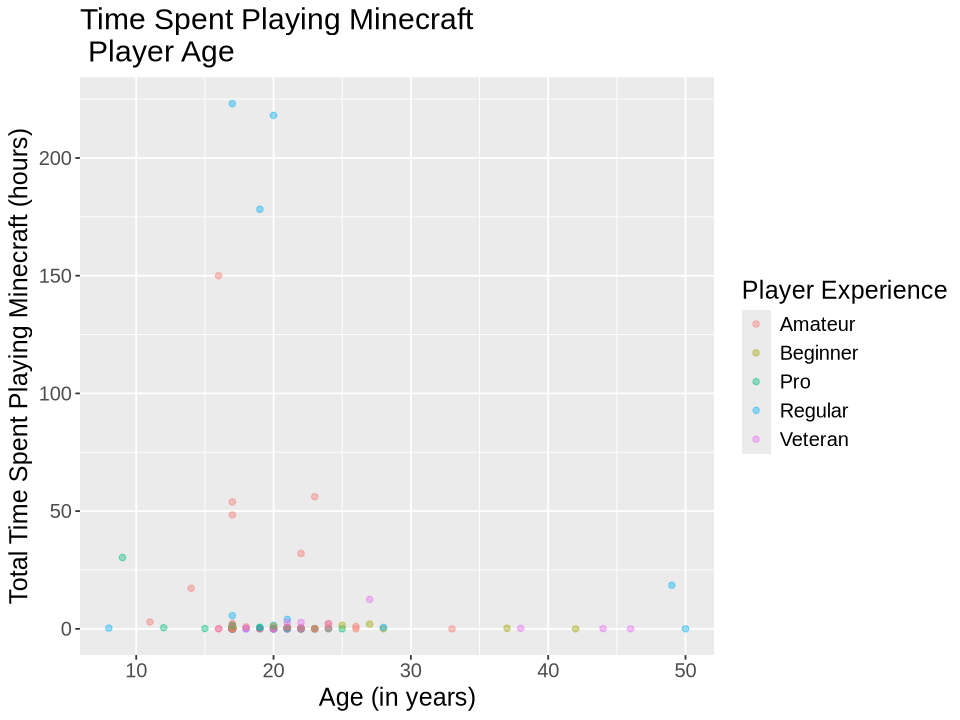

In [8]:
# exploratory vizualization 1: do age or player experience affect total time spent playing Minecraft?
players_training <- mutate(players_training, Age = Age, na.rm = TRUE)
age_effect_plot <- ggplot(players_training, aes(x = Age, y = played_hours, colour = experience)) + 
geom_point(alpha = 0.4) + 
labs(x = "Age (in years)", y = "Total Time Spent Playing Minecraft (hours)", colour = "Player Experience", title = "Time Spent Playing Minecraft \n Player Age") + 
theme(text = element_text(size = 15))
options(repr.plot.height = 6, repr.plot.width = 8)
age_effect_plot

This visualization hints that players around 15-27 years of age may have spent the most time in total playing Minecraft. It can also be seen that the majority of participants fell within this age range which may influence this interpretation. There appears to be no clear relationship between player experience and the total time spent playing Minecraft, however, the data points indicating the longest total time spent playing Minecraft represent players at a "Regular" level, and other high points belong to players at an "Amateur" level. This visualization may indicate that age and player experience could influence the total time spent playing Minecraft.

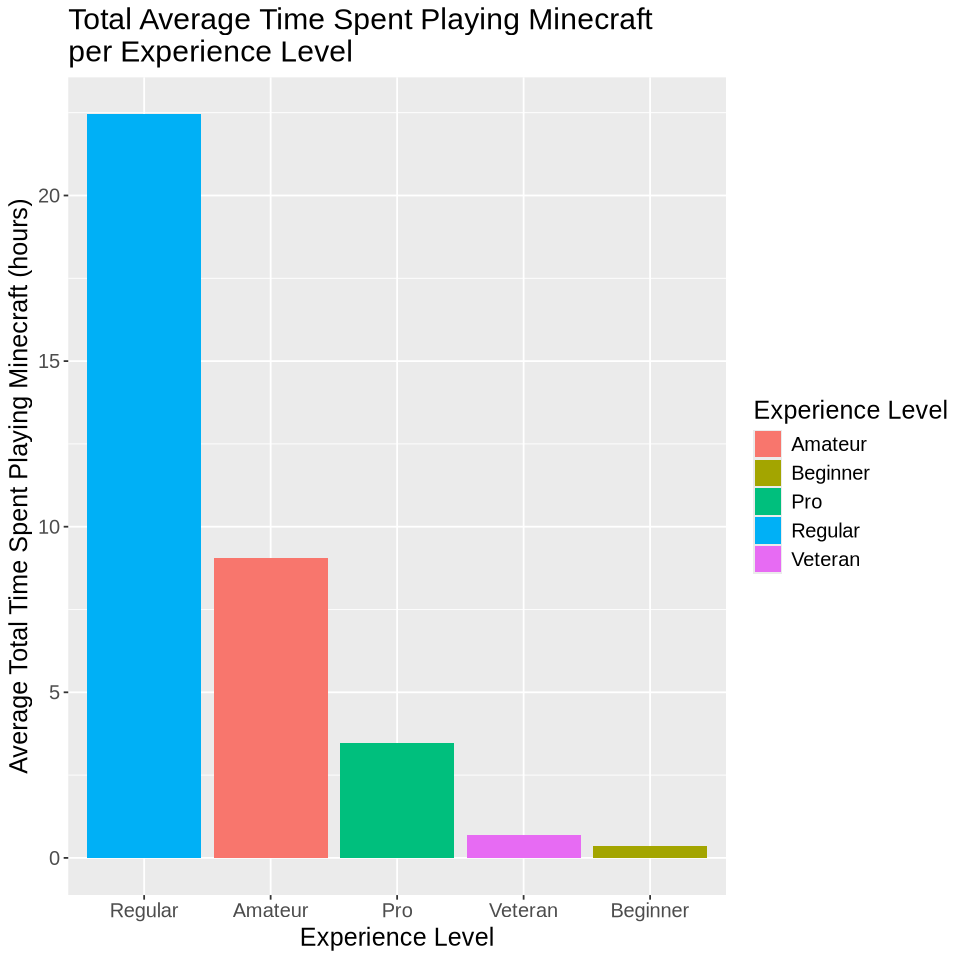

In [9]:
# exploratory visualization 2: What is the average time spent playing Minecraft based on player experience?
players_experience_avg <- players_training |>
    group_by(experience) |>
    summarize(mean_hours = mean(played_hours)) 

experience_plot <- ggplot(players_experience_avg, aes(x = fct_reorder(experience, mean_hours, .desc = TRUE), y = mean_hours, fill = experience)) + 
geom_bar(stat = "identity") + 
labs(x = "Experience Level", y = "Average Total Time Spent Playing Minecraft (hours)", title = "Total Average Time Spent Playing Minecraft \nper Experience Level", fill = "Experience Level") + 
theme(text = element_text(size = 15)) 
options(repr.plot.height = 8, repr.plot.width = 8)
experience_plot


This visualization supports the findings of the above scatter plot in terms of the effect of player experience on the total time spent playing Minecraft. It can be seen that the highest average of total time spent playing the game was achieved by players at the "Regular" experience level and the second highest average belonged to players at the "Amateur" experience level. This visualization may hint that player experience level could influence the time spent playing Minecraft (and therefore help predict which players will provide more data).

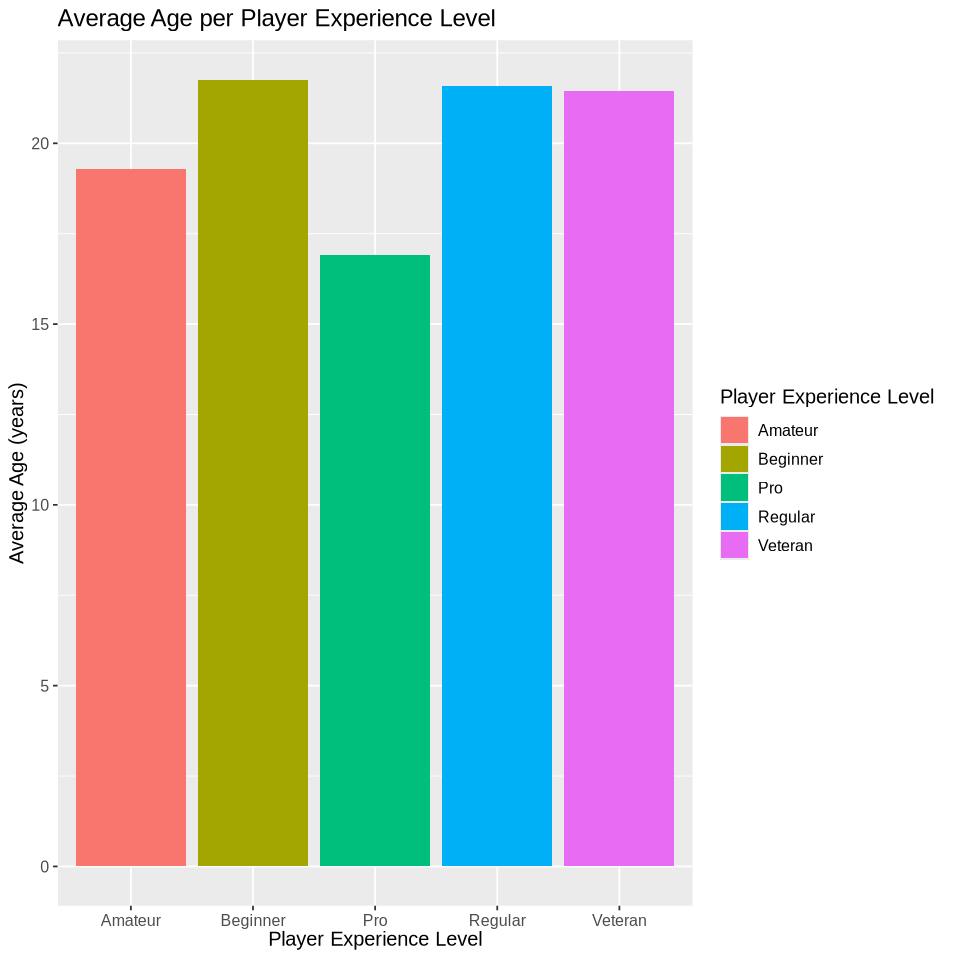

In [10]:
# exploratory visualization 3: average age per experience level
average_age <- players_training |>
    group_by(experience) |>
    summarize(average_age = mean(Age, na.rm = TRUE))
age_exp_plot <- ggplot(average_age, aes(x = experience, y = average_age, fill = experience)) + 
geom_bar(stat = "identity") + 
labs(x = "Player Experience Level", y = "Average Age (years)", title = "Average Age per Player Experience Level", fill = "Player Experience Level") + 
theme(text = element_text(size = 12))
options(repr.plot.height = 8, repr.plot.width = 8)
age_exp_plot

It seems that the average age of players is quite similar for the different levels of experience, around 20 years of age. The average age of players at the "Pro" level is noticeably slightly lower than the other bars. It seems that age does not fully influence the experience level of players, although this may indicate that many participants were around the age of 20, since it was found earlier that the mean age of all participants was also 20 years of age.

In [12]:
# code to split sessions_data into a training set and a testing set
sessions_split <- initial_split(sessions_data, prop = 0.70)
sessions_training <- training(sessions_split)
sessions_testing <- testing(sessions_split)

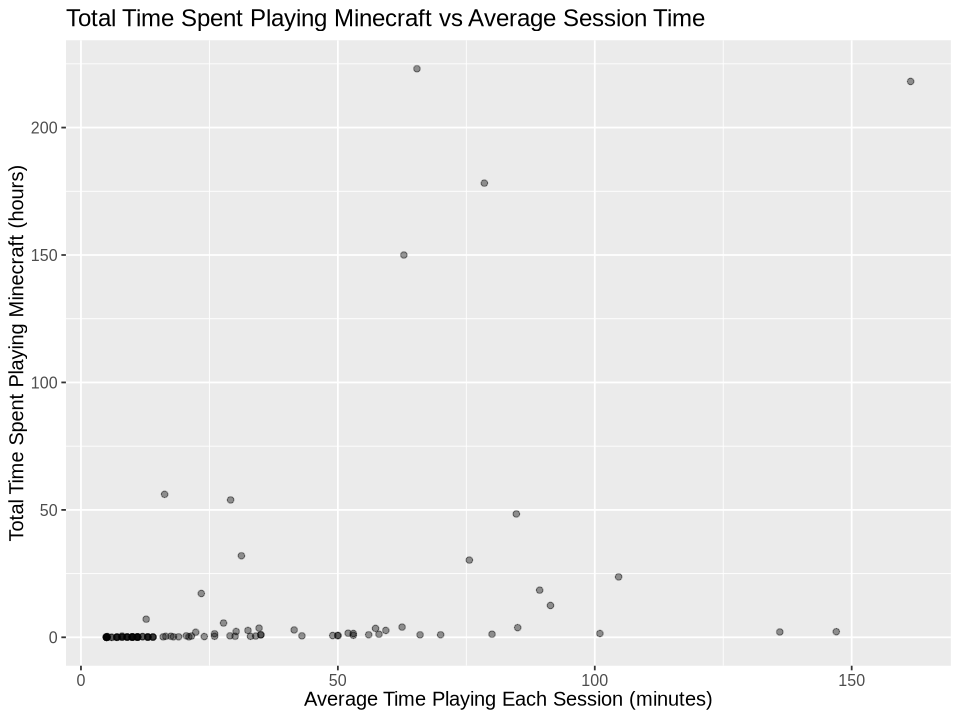

In [13]:
# exploratory visualization 4: average playing session time vs total time spent playing Minecraft
sessions_mutate <- sessions_training |>
    mutate(start_date_time = dmy_hm(start_time), 
           end_date_time = dmy_hm(end_time), 
           session_time = as.numeric(difftime(end_date_time, start_date_time, units = "mins")))

sessions_average <- sessions_mutate |>
    group_by(hashedEmail) |>
    summarize(session_average = mean(session_time, na.rm = TRUE))

combined_data <- sessions_average |>
    inner_join(players_data, by = "hashedEmail")

avg_session_vs_total <- ggplot(combined_data, aes(x = session_average, y = played_hours)) + 
geom_point(alpha = 0.4) + 
labs(x = "Average Time Playing Each Session (minutes)", y = "Total Time Spent Playing Minecraft (hours)", title = "Total Time Spent Playing Minecraft vs Average Session Time") + 
theme(text = element_text(size = 12)) 
options(repr.plot.height = 6, repr.plot.width = 8)
avg_session_vs_total

From the above visualization, it can be seen that there seems to be no clear relationship between the average time spent each session playing Minecraft and the total time spent playing the game. perhaps the use of average session time as a predictor variable will decrease the accuracy of the predictive model. It may be necessary to remove the average session time as a predictor variable, although its use as a predictor can be evaluated when constructing the predictive model.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


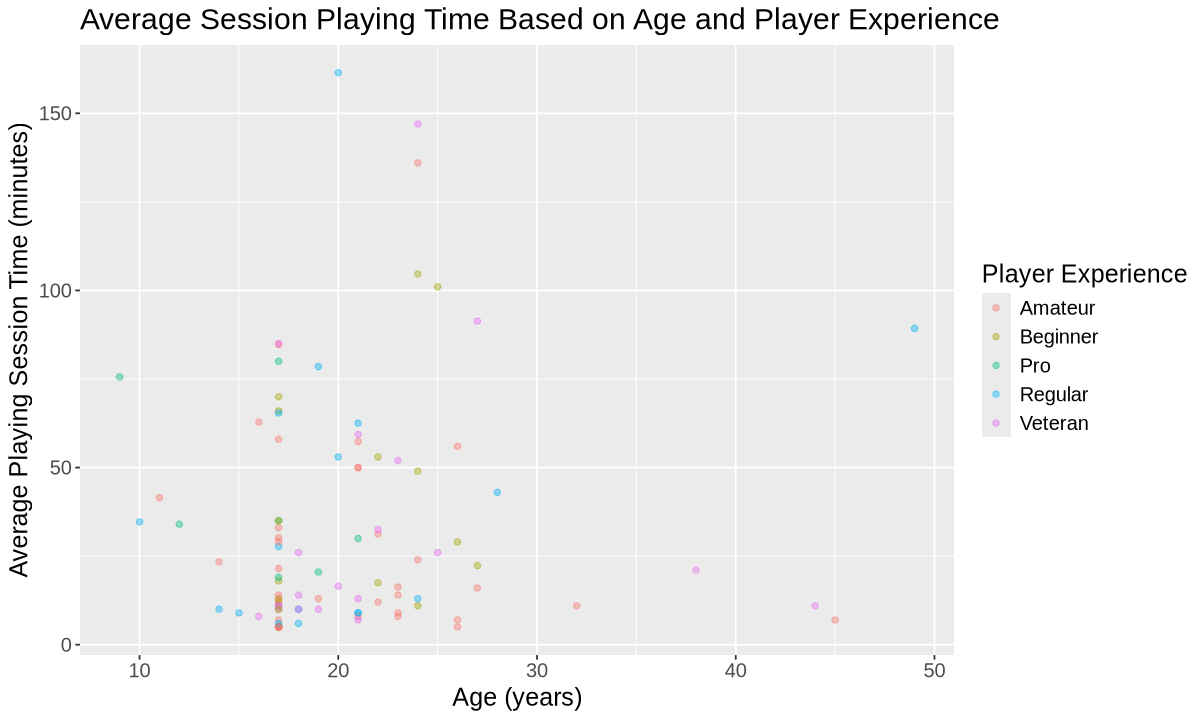

In [14]:
options(repr.plot.height = 6, repr.plot.width = 10)
age_exp_vs_time <- ggplot(combined_data, aes(x = Age, y = session_average, color = experience)) + 
geom_point(alpha = 0.4) + 
labs(x = "Age (years)", y = "Average Playing Session Time (minutes)", title = "Average Session Playing Time Based on Age and Player Experience", color = "Player Experience") + 
theme(text = element_text(size = 15))
age_exp_vs_time

It can be seen from the visualization that the highest average playing session times were achieved by participants around 15-25 years of age, with the longest average playing session time belonging to a 20-year-old participant. This may be due in part to the fact that many of the participants fell within this age range, alrhough there is a possibility that age and average playing session length are related. There appears to be no clear relationship between player experience and the average length of each playing session, although it can be noted that the longest average playing session time belongs to a participant at a "Regular" experience level.  

<h3>(4) Methods and Plan</h3>

To answer the predictive question specified in part (2), it will be necessary to construct a predictive model for the data. Since the response variable selected is the total amount of time spent playing Minecraft, which is numerical, a regression model would be most appropriate. Linear regression could work if the assumption is made that there will be a linear relationship between the predictors and the response variable. Based on the visualizations above, it seems like this will be unlikely, so linear regression will be avoided. This model wmay be able to predict the total number of hours spent playing Minecraft, but since it is not linear regression, it will be difficult to extrapolate the data or to make predictions based on observations outside of the range of collected data. The K value will be selected through the use of 5-fold cross-validation, choosing the K value that yields the lowest RMSE. When establishing the model, the data will be split into a training and testing set (with a 70% to 30% proportion), and the training set will be used in cross-validation to select K and also to create a workflow. The data has already been split in part (3) above, since the training data set was most appropriate to use when generating the exploratory visualizations. The workflow will be used to predict the total time spent playing Minecraft for the testing set and can then be evaluated. It may be helpful to run a similar analysis using linear regression and compare the RMSPE values to determine whether linear regression would yield a better predictive model.